In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import sys
print(sys.version)

3.10.11 | packaged by Anaconda, Inc. | (main, May 16 2023, 00:55:32) [MSC v.1916 64 bit (AMD64)]


In [3]:
import os
import numpy as np
import pandas
import cv2
import matplotlib.pyplot as plt
import csv
import random
from skimage.transform import rotate
import joblib
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split

## Set class names

In [4]:
class_names = {
    0: "Speed limit (20km/h)", 1: "Speed limit (30km/h)", 2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)", 4: "Speed limit (70km/h)", 5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)", 7: "Speed limit (100km/h)", 8: "Speed limit (120km/h)",
    9: "No passing", 10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection", 12: "Priority road", 13: "Yield",
    14: "Stop", 15: "No vehicles", 16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry", 18: "General caution", 19: "Dangerous curve to the left",
    20: "Dangerous curve to the right", 21: "Double curve", 22: "Bumpy road",
    23: "Slippery road", 24: "Road narrows on the right", 25: "Road work",
    26: "Traffic signals", 27: "Pedestrians", 28: "Children crossing",
    29: "Bicycles crossing", 30: "Beware of ice/snow", 31: "Wild animals crossing",
    32: "End of all speed and passing limits", 33: "Turn right ahead",
    34: "Turn left ahead", 35: "Ahead only", 36: "Go straight or right",
    37: "Go straight or left", 38: "Keep right", 39: "Keep left",
    40: "Roundabout mandatory", 41: "End of no passing",
    42: "End of no passing for vehicles over 3.5 metric tons"
}

## Load images for NN

In [5]:
#Courtesy of GTSRB website

# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader)  # skip header 
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels


I,L = readTrafficSigns("E:\\Semester2\\Machine Learning\\GTSRB_Data\\Final_Training\\images")

In [6]:
print("Total images:", len(I))
print("Total labels:", len(L))
if(len(I)==len(L)):
    print("No mismatches detected")

Total images: 39209
Total labels: 39209
No mismatches detected


In [7]:
def augment_with_rotation(images, labels, rotation_range=(-15, 15), n=1): #Creates n altered copies of each image, start with 1 for now
    augmented_images = []
    augmented_labels = []
    
    for image, label in zip(images, labels):
        augmented_images.append(image)
        augmented_labels.append(label)
        
        for _ in range(n):
            angle = random.uniform(rotation_range[0], rotation_range[1])
            rotated = rotate(image, angle, mode='edge')  #helps with border artifacts
            augmented_images.append((rotated * 255).astype(np.uint8))  # Convert back to 0-255 range
            augmented_labels.append(label)
    
    return augmented_images, augmented_labels
augmented_I, augmented_L = augment_with_rotation(I, L, rotation_range=(-10, 10), n=1)

In [8]:
print(f"Original dataset size: {len(I)}")
print(f"Augmented dataset size: {len(augmented_I)}")

Original dataset size: 39209
Augmented dataset size: 78418


In [9]:
#resize to 48x48
augmented_I = [cv2.resize(img, (48, 48)) for img in augmented_I]

In [10]:
#augmented_I_Gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in augmented_I_RGB])
augmented_I = np.array(augmented_I)
augmented_I_RGB = []
augmented_I_Gray = []

for img in augmented_I:
    #Convert to grayscale (from BGR as thats what cv2 uses)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    augmented_I_Gray.append(gray_img)
    augmented_I_RGB.append(img)  

augmented_I_RGB = np.array(augmented_I_RGB)  # Shape: (N, 48, 48, 3) in BGR
augmented_I_Gray = np.array(augmented_I_Gray)  # Shape: (N, 48, 48)

#Labels remain unchanged
print(f"RGB images shape: {augmented_I_RGB.shape}")
print(f"Grayscale images shape: {augmented_I_Gray.shape}")
print(f"Labels count: {len(augmented_L)}")  # Should match N

RGB images shape: (78418, 48, 48, 3)
Grayscale images shape: (78418, 48, 48)
Labels count: 78418


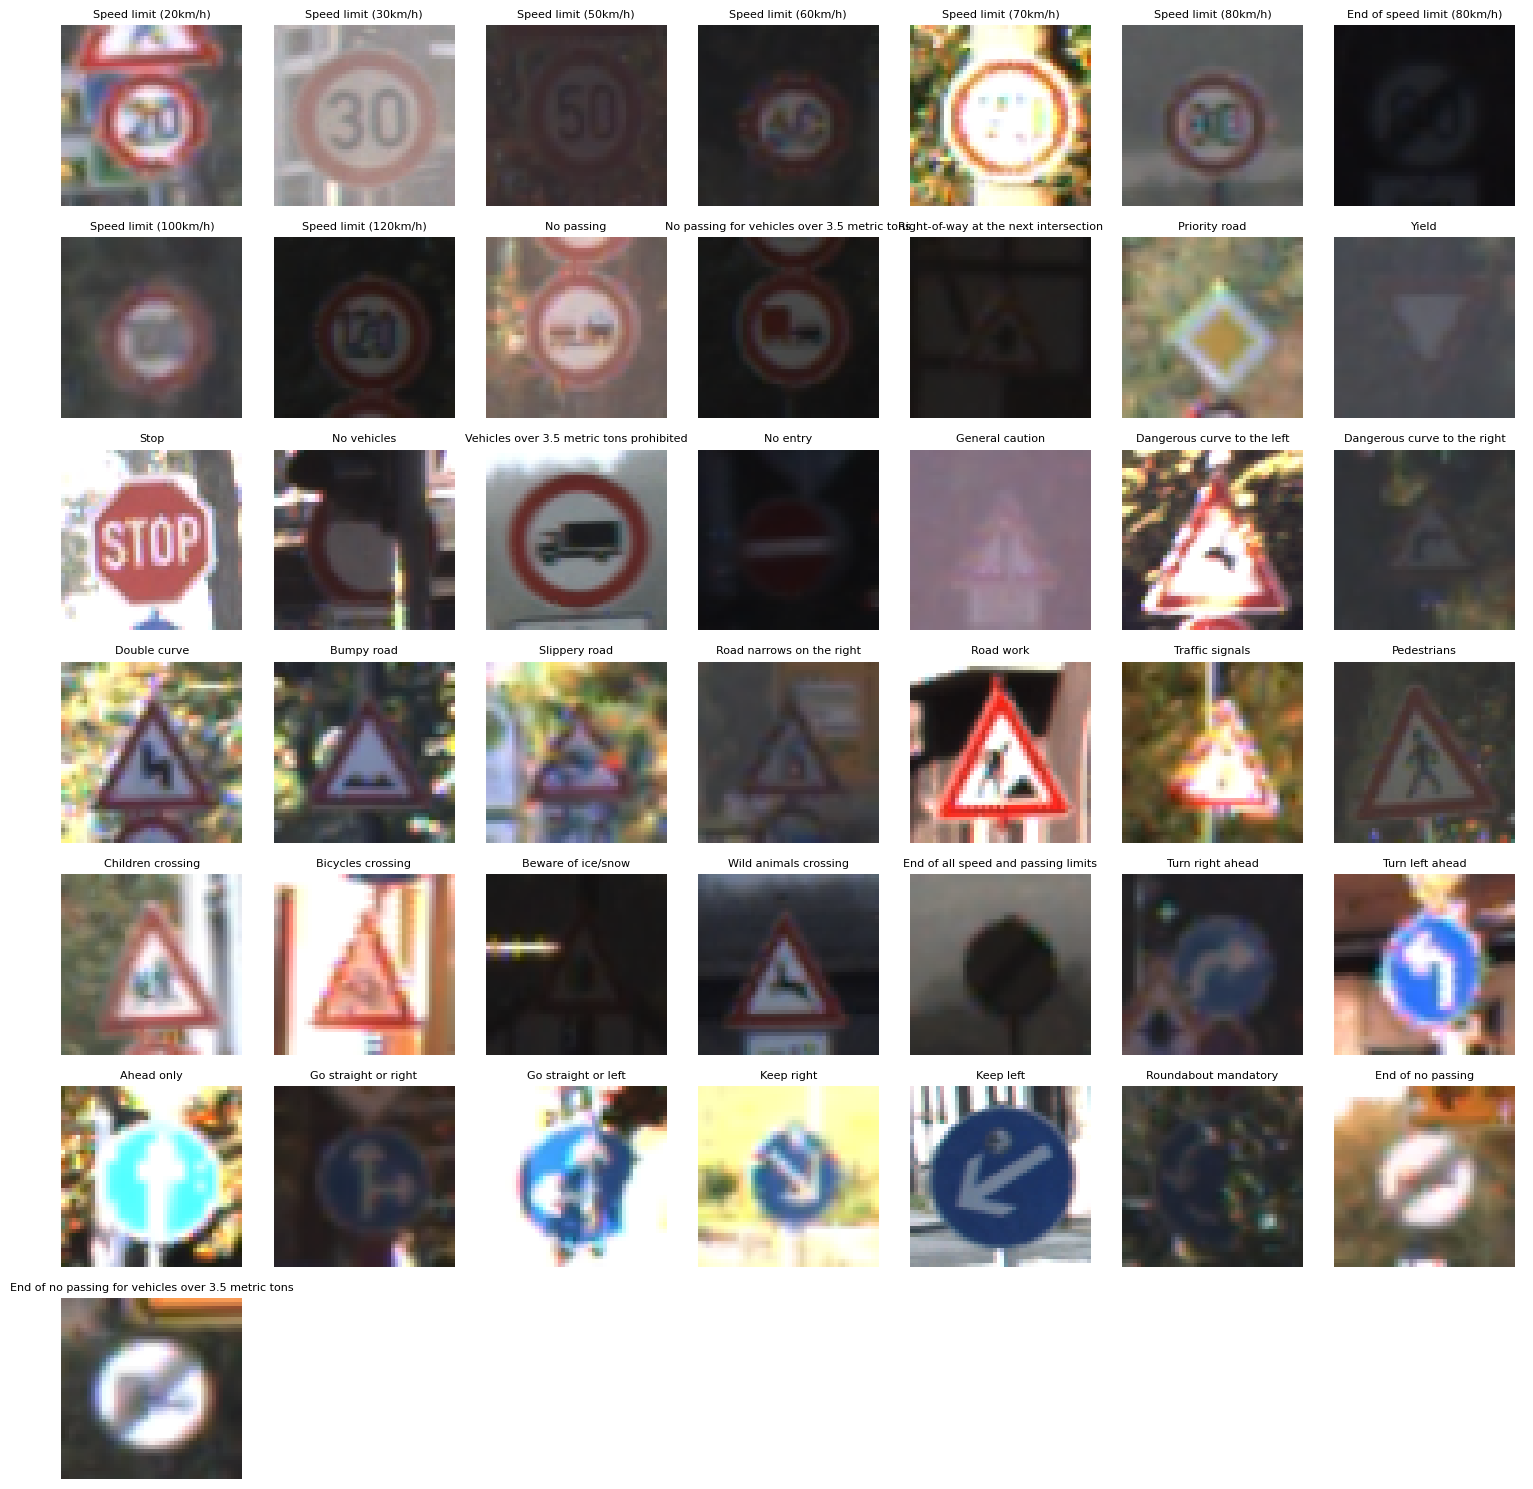

In [11]:
images_per_class = {}

#Loop through the list of labels and images (I, L) 
for image, label in zip(augmented_I_RGB, augmented_L):
                                        #Stores the first image in each class
    if label not in images_per_class:
        images_per_class[label] = image

fig, axes = plt.subplots(7, 7, figsize=(15, 15))  
axes = axes.flatten()  

#Loop through the images_per_class dictionary and plot the images
for idx, (label, image) in enumerate(images_per_class.items()):
    axes[idx].imshow(image) 
    axes[idx].set_title(class_names[int(label)], fontsize=8)  
    axes[idx].axis('off')  

for i in range(len(images_per_class), len(axes)):
    axes[i].axis('off')

plt.tight_layout() 
plt.show()

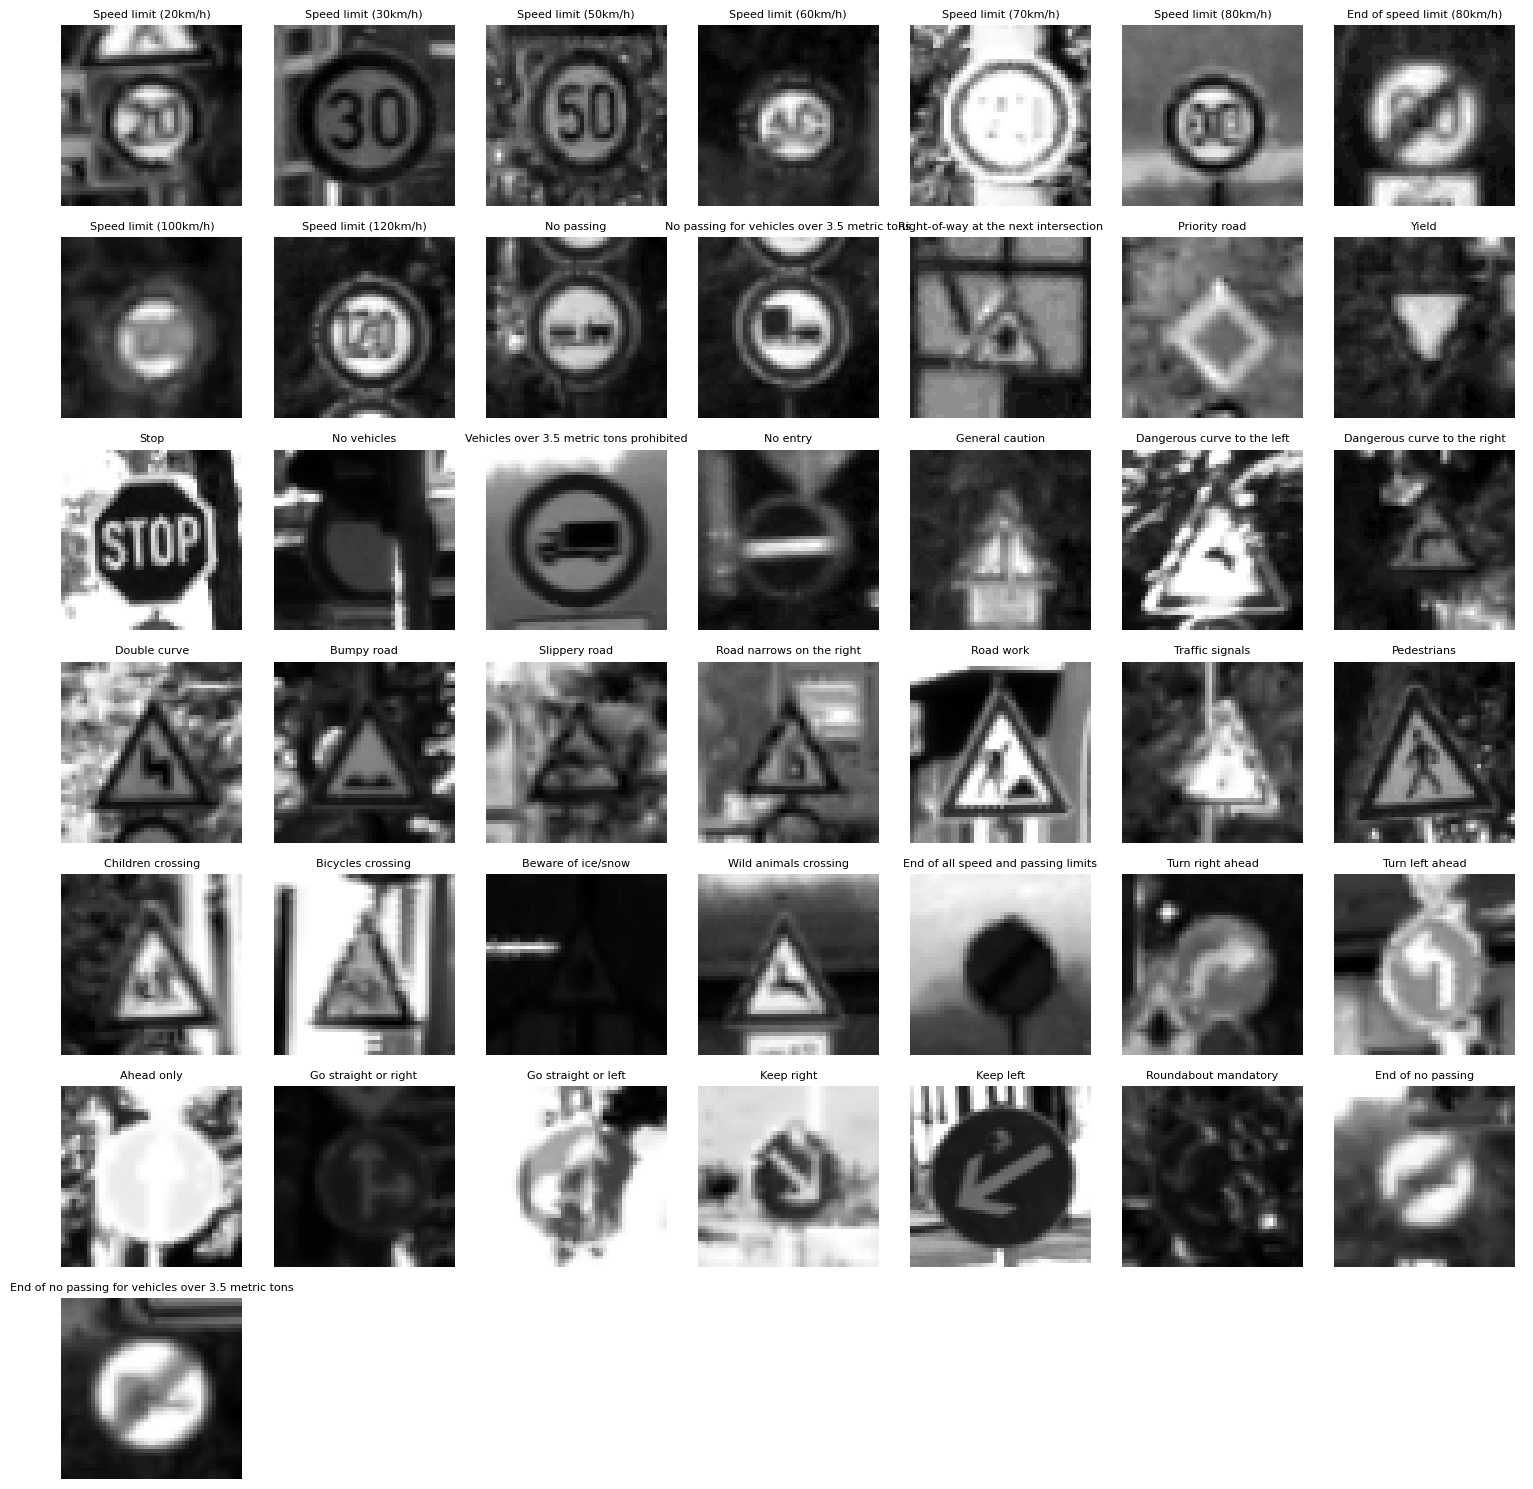

In [12]:
images_per_class = {}

#Loop through the list of labels and images (I, L) 
for image, label in zip(augmented_I_Gray, augmented_L):
                                        #Stores the first image in each class
    if label not in images_per_class:
        images_per_class[label] = image

fig, axes = plt.subplots(7, 7, figsize=(15, 15))  
axes = axes.flatten()  

#Loop through the images_per_class dictionary and plot the images
for idx, (label, image) in enumerate(images_per_class.items()):
    axes[idx].imshow(image,cmap="gray") 
    axes[idx].set_title(class_names[int(label)], fontsize=8)  
    axes[idx].axis('off')  

for i in range(len(images_per_class), len(axes)):
    axes[i].axis('off')

plt.tight_layout() 
plt.show()

## NN

In [13]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import to_categorical

In [14]:
X = augmented_I_Gray
y = augmented_L  
print(len(X),len(y))

78418 78418


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [16]:
#Convert string labels to integers and then to one-hot encoding
y_train_int = np.array(y_train).astype(int)
y_train_onehot = to_categorical(y_train_int, num_classes=43)

#pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0

#Create multiple columns
def create_branch(input_shape=(48, 48, 1)):
    inputs = Input(shape=input_shape)
    #Layer 1: Conv 7x7, 100 maps of 42×42
    x = layers.Conv2D(100, (7, 7), activation='relu')(inputs)
    #Layer 2: MaxPool 2x2, 100 maps of 21×21
    x = layers.MaxPooling2D((2, 2))(x)
    #Layer 3: Conv 4x4, 150 maps of 18×18
    x = layers.Conv2D(150, (4, 4), activation='relu')(x)
    #Layer 4: MaxPool 2x2 , 150 maps of 9×9
    x = layers.MaxPooling2D((2, 2))(x)
    #Layer 5: Conv 4x4, 250 maps of 6×6
    x = layers.Conv2D(250, (4, 4), activation='relu')(x)
    #Layer 6: MaxPool 2x2 ,250 maps of 3×3
    x = layers.MaxPooling2D((2, 2))(x)
    #Flatten
    x = layers.Flatten()(x)
    
    return inputs, x

#Create n many branches
num_branches = 5
branch_inputs = []
branch_outputs = []
for _ in range(num_branches):
    inp, out = create_branch()
    branch_inputs.append(inp)
    branch_outputs.append(out)
#combine our branches
merged = layers.concatenate(branch_outputs)

#conected layers
#Layer 7: Fully connected 300 neurons
x = layers.Dense(300, activation='relu')(merged)
x = layers.Dropout(0.5)(x)  #dropout for regularization

#layer 8 - output (43)
outputs = layers.Dense(43, activation='softmax')(x)

#Create model
model = models.Model(inputs=branch_inputs, outputs=outputs)

#Early stop
early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
)
#compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#input data - duplicate for each branch
X_train_multi = [X_train] * num_branches


#Train
history = model.fit(X_train_multi, y_train_onehot,
                    epochs=50,
                    batch_size=64,
                    callbacks=[early_stopping],
                    validation_split=0.2,
                    verbose=1)

#View model architecture
model.summary()

Epoch 1/50
785/785 [==============================] - 46s 54ms/step - loss: 0.8621 - accuracy: 0.7634 - val_loss: 0.0651 - val_accuracy: 0.9833
Epoch 2/50
785/785 [==============================] - 42s 53ms/step - loss: 0.1172 - accuracy: 0.9656 - val_loss: 0.0373 - val_accuracy: 0.9907
Epoch 3/50
785/785 [==============================] - 42s 53ms/step - loss: 0.0700 - accuracy: 0.9785 - val_loss: 0.0199 - val_accuracy: 0.9955
Epoch 4/50
785/785 [==============================] - 42s 53ms/step - loss: 0.0498 - accuracy: 0.9847 - val_loss: 0.0224 - val_accuracy: 0.9935
Epoch 5/50
785/785 [==============================] - 42s 53ms/step - loss: 0.0484 - accuracy: 0.9862 - val_loss: 0.0099 - val_accuracy: 0.9976
Epoch 6/50
785/785 [==============================] - 42s 53ms/step - loss: 0.0331 - accuracy: 0.9904 - val_loss: 0.0143 - val_accuracy: 0.9963
Epoch 7/50
785/785 [==============================] - 42s 53ms/step - loss: 0.0406 - accuracy: 0.9883 - val_loss: 0.0131 - val_accuracy:

## Evaluation

Training Accuracy: 0.9916
Validation Accuracy: 0.9978
Test Accuracy: 0.9956

491/491 [==============================] - 4s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        84
           1       1.00      1.00      1.00       888
           2       1.00      1.00      1.00       900
           3       1.00      0.97      0.98       564
           4       1.00      1.00      1.00       792
           5       0.97      0.99      0.98       744
           6       1.00      1.00      1.00       168
           7       1.00      0.98      0.99       576
           8       0.99      1.00      0.99       564
           9       1.00      1.00      1.00       588
          10       1.00      1.00      1.00       804
          11       1.00      1.00      1.00       528
          12       1.00      1.00      1.00       840
          13       1.00      1.00      1.00       864
          14       1.00      1.00 

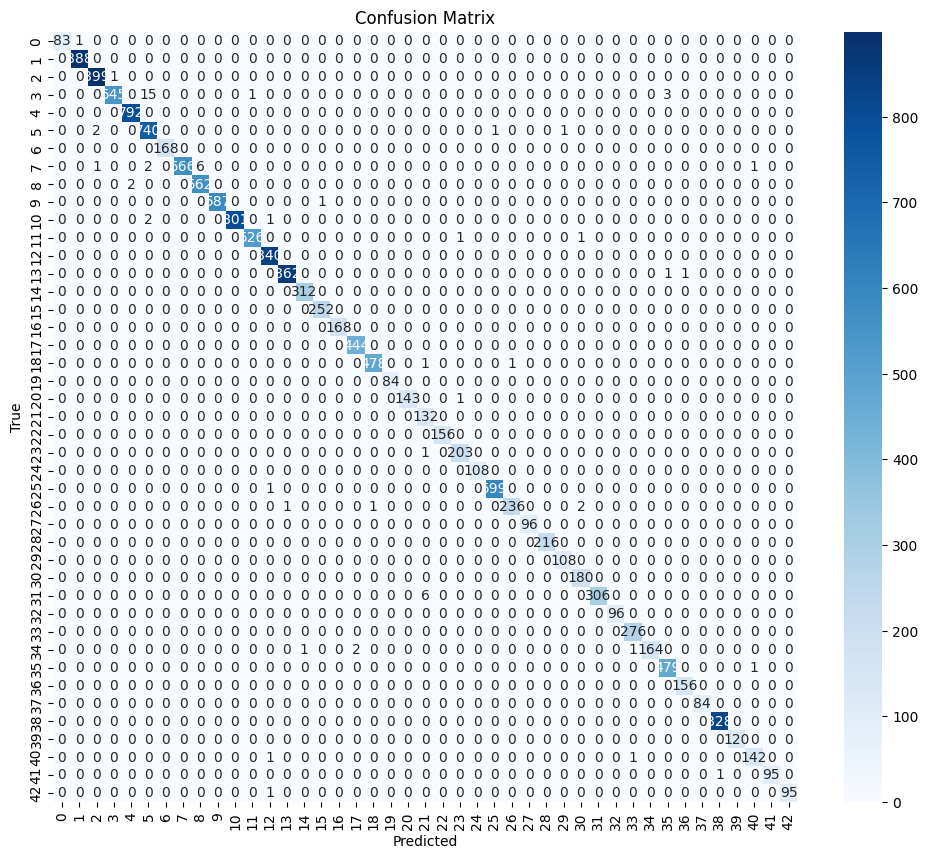

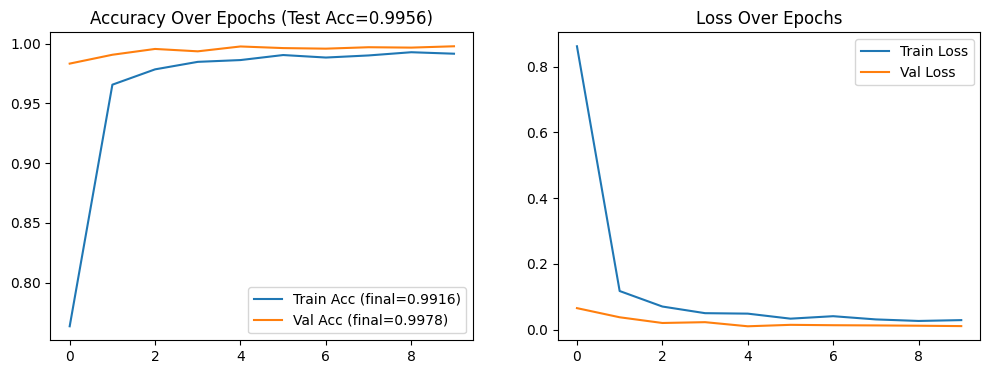

Overall Precision: 0.9957
Overall Recall: 0.9956
Overall F1-Score: 0.9956


In [17]:
#Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Generate predictions
X_test_multi = [X_test] * num_branches  
y_test_int = np.array(y_test).astype(int)
y_test_onehot = to_categorical(y_test_int, num_classes=43)

#Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_multi, y_test_onehot, verbose=0)

#Get training accuracy from history
train_acc = history.history['accuracy'][-1]  # Last epoch's training accuracy
val_acc = history.history['val_accuracy'][-1]  # Last epoch's validation accuracy

#Print accuracies
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}\n")

#Generate predictions
y_pred = model.predict(X_test_multi) 
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

#Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(43)]))

#Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#Accuracy and loss plots
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label=f'Train Acc (final={train_acc:.4f})')
plt.plot(history.history['val_accuracy'], label=f'Val Acc (final={val_acc:.4f})')
plt.title(f"Accuracy Over Epochs (Test Acc={test_acc:.4f})")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.legend()
plt.show()

#Additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score
print(f"Overall Precision: {precision_score(y_true, y_pred_classes, average='weighted'):.4f}")
print(f"Overall Recall: {recall_score(y_true, y_pred_classes, average='weighted'):.4f}")
print(f"Overall F1-Score: {f1_score(y_true, y_pred_classes, average='weighted'):.4f}")

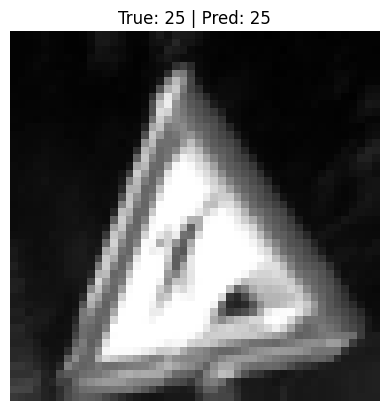

Inference time: 46.89ms
True label: 25 | Predicted: 25
Confidence: 100.00%


In [18]:
#Inference
import time

def test_random_sample(model):
    idx = np.random.randint(len(augmented_I_Gray))   #Pick random index
    img, label = augmented_I_Gray[idx], augmented_L[idx]
    
    # Prepare image (add batch dim)
    x = np.expand_dims(img, axis=0)  # Shape: (1, 48, 48, 3)
    x_multi = [x] * num_branches  #Create a list of 5 identical inputs
    
    # Warm-up
    model.predict(x_multi, verbose=0)
    
    # Time inference (average over 10 runs)
    times = []
    for _ in range(10):
        start = time.time()
        pred = model.predict(x_multi, verbose=0)
        times.append(time.time() - start)
    
    avg_time = np.mean(times) * 1000  #Average all measured runs
    
    #Display
    plt.imshow(img,cmap="gray") 
    plt.title(f"True: {label} | Pred: {np.argmax(pred)}")
    plt.axis('off')
    plt.show()
    
    print(f"Inference time: {avg_time:.2f}ms")
    print(f"True label: {label} | Predicted: {np.argmax(pred)}")
    print(f"Confidence: {np.max(pred):.2%}")

test_random_sample(model)

#### 10 wrong examples

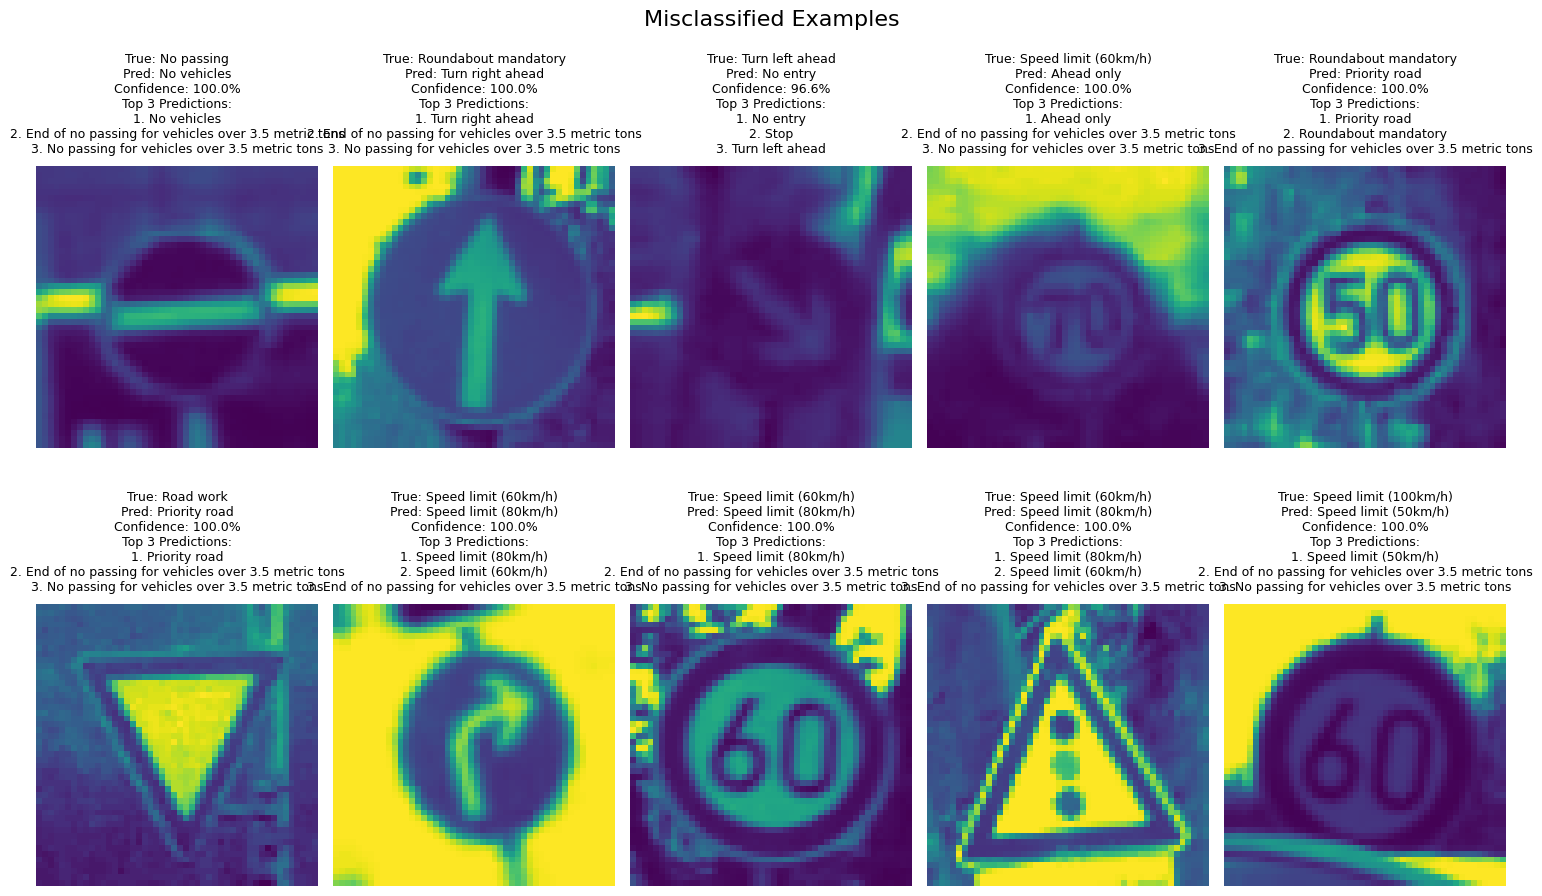

In [19]:
#misclassified examples
wrong_indices = np.where(y_pred_classes != y_true)[0]
np.random.shuffle(wrong_indices)  # Randomize which errors we show

plt.figure(figsize=(15,10))
plt.suptitle("Misclassified Examples", fontsize=16)

for i, idx in enumerate(wrong_indices[:10]):
    plt.subplot(2, 5, i+1)
    
    # Display image (handling both normalized and unnormalized)
    img = (X_train[idx] * 255).astype('uint8') if X_train[idx].max() <= 1 else X_train[idx]
    plt.imshow(img)
    
    #Get prediction info
    true_class = y_true[idx]
    pred_class = y_pred_classes[idx]
    confidence = np.max(y_pred[idx])
    top3_probs = np.argsort(y_pred[idx])[-3:][::-1]
    
    # Create descriptive label
    label_text = (f"True: {class_names[true_class]}\n"
                 f"Pred: {class_names[pred_class]}\n"
                 f"Confidence: {confidence:.1%}\n"
                 f"Top 3 Predictions:\n"
                 f"1. {class_names[top3_probs[0]]}\n"
                 f"2. {class_names[top3_probs[1]]}\n"
                 f"3. {class_names[top3_probs[2]]}")
    
    plt.title(label_text, fontsize=9, pad=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

#### 20 wrong examples

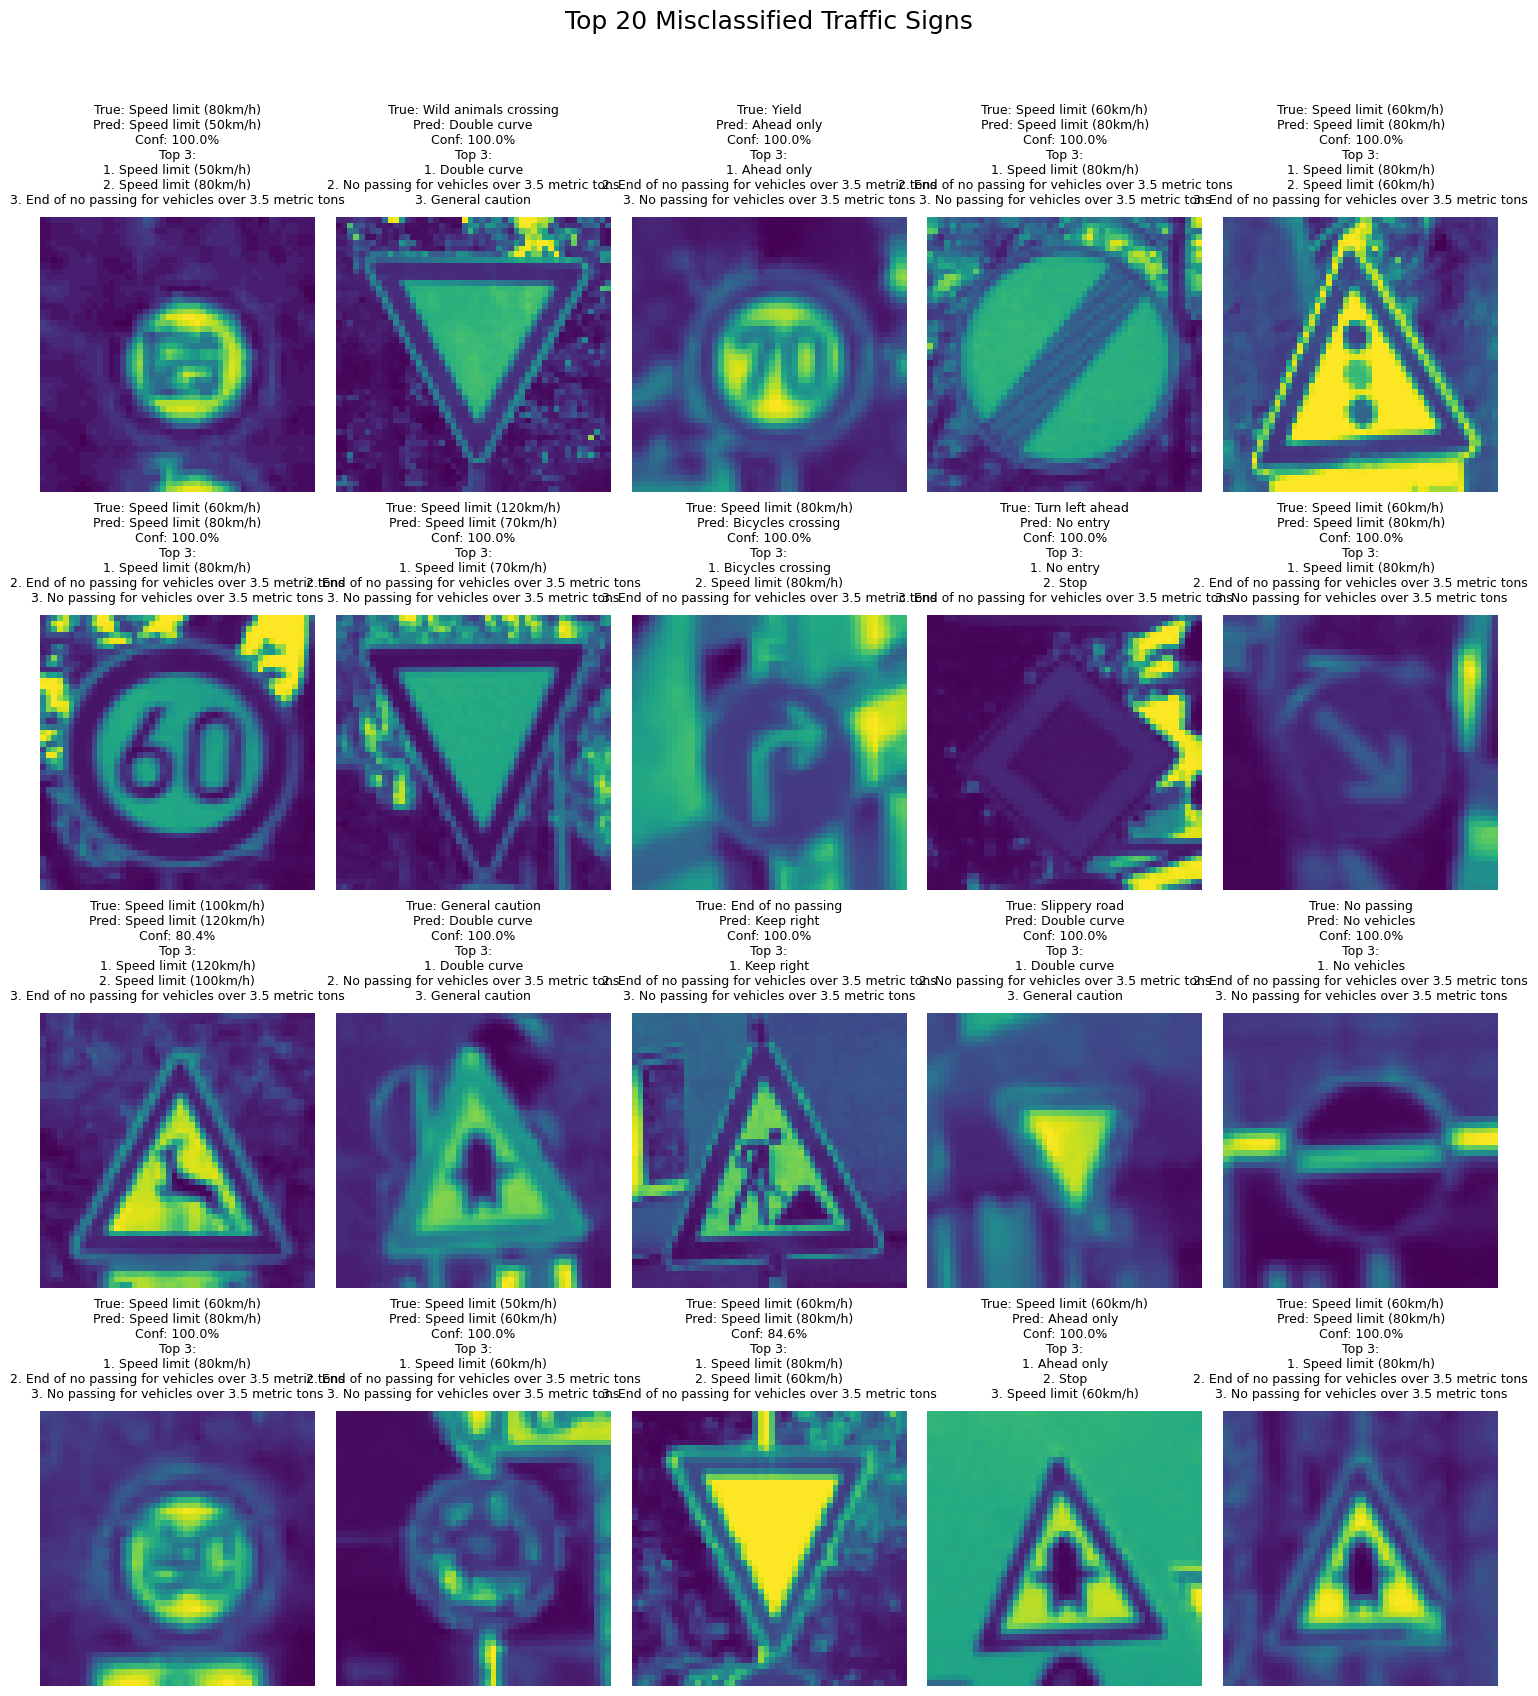

In [20]:
#Get misclassified examples
wrong_indices = np.where(y_pred_classes != y_true)[0]
np.random.shuffle(wrong_indices)  # Randomize which errors we show

#set up larger figure for 20 examples
plt.figure(figsize=(15, 17))
plt.suptitle("Top 20 Misclassified Traffic Signs", fontsize=18, y=1.02)

#Display 20 wrong predictions in 4 rows of 5
for i, idx in enumerate(wrong_indices[:20]):
    plt.subplot(4, 5, i+1)  #4 rows 5 cols
    
    img = (X_train[idx] * 255).astype('uint8') if X_train[idx].max() <= 1 else X_train[idx]
    plt.imshow(img)
    
    #info
    true_class = y_true[idx]
    pred_class = y_pred_classes[idx]
    confidence = np.max(y_pred[idx])
    top3_probs = np.argsort(y_pred[idx])[-3:][::-1]
    
    #label
    label_text = (f"True: {class_names[true_class]}\n"
                 f"Pred: {class_names[pred_class]}\n"
                 f"Conf: {confidence:.1%}\n"
                 f"Top 3:\n"
                 f"1. {class_names[top3_probs[0]]}\n"
                 f"2. {class_names[top3_probs[1]]}\n"
                 f"3. {class_names[top3_probs[2]]}")
    
    plt.title(label_text, fontsize=9, pad=10)  
    plt.axis('off')

plt.tight_layout(pad=1.5)
plt.show()

In [22]:
from codecarbon import EmissionsTracker
tracker = EmissionsTracker()
tracker.start()
model.predict(X_test_multi)
emissions_MCDNNG = tracker.stop()
print(f"Emissions for Random Forest: {emissions_MCDNNG} kg CO2")

[codecarbon WARNING @ 10:51:29] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:51:29] [setup] RAM Tracking...
[codecarbon INFO @ 10:51:29] [setup] CPU Tracking...
[codecarbon WARNING @ 10:51:30] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 10:51:30] CPU Model on constant consumption mode: AMD Ryzen 9 5900XT 16-Core Processor
[codecarbon WARNING @ 10:51:30] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:51:30] [setup] GPU Tracking...
[codecarbon INFO @ 10:51:30] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 10:51:30] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 10:51:30] >>> Tracker's metad

491/491 [==============================] - 4s 8ms/step


[codecarbon INFO @ 10:51:38] Energy consumed for RAM : 0.000025 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:51:38] Delta energy consumed for CPU with constant : 0.002077 kWh, power : 1680.0 W
[codecarbon INFO @ 10:51:38] Energy consumed for All CPU : 0.002077 kWh
[codecarbon INFO @ 10:51:38] Energy consumed for all GPUs : 0.000123 kWh. Total GPU Power : 99.72026095627385 W
[codecarbon INFO @ 10:51:38] 0.002225 kWh of electricity used since the beginning.


Emissions for Random Forest: 0.0006469325428620722 kg CO2


[codecarbon INFO @ 10:51:38] Energy consumed for RAM : 0.002416 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:51:38] Delta energy consumed for CPU with constant : 0.007001 kWh, power : 1680.0 W
[codecarbon INFO @ 10:51:38] Energy consumed for All CPU : 0.203045 kWh
[codecarbon INFO @ 10:51:38] Energy consumed for all GPUs : 0.000929 kWh. Total GPU Power : 35.0382297921279 W
[codecarbon INFO @ 10:51:38] 0.206390 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:51:53] Energy consumed for RAM : 0.002500 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:51:53] Delta energy consumed for CPU with constant : 0.007002 kWh, power : 1680.0 W
[codecarbon INFO @ 10:51:53] Energy consumed for All CPU : 0.210047 kWh
[codecarbon INFO @ 10:51:53] Energy consumed for all GPUs : 0.000981 kWh. Total GPU Power : 12.499268455285515 W
[codecarbon INFO @ 10:51:53] 0.213528 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:52:08] Energy consumed for RAM : 0.002583 kWh. RAM Power